02 파일과 feature 동일, 5model 조합 테스트

### 모델 (5개)
1. **LightGBM** - Gradient Boosting (Tree 기반)
2. **CatBoost** - 범주형 변수 특화
3. **XGBoost** - 정규화 강화
4. **Random Forest** - Bagging (Diversity)
5. **Logistic Regression** - Polynomial Features (선형 + 2차 상호작용)

### 앙상블 방법 (5가지)
1. **Simple Averaging** - 단순 평균
2. **Weighted Averaging** - CV AUC 기반 가중 평균
3. **Rank Averaging** - 순위 기반 평균
4. **Weighted Rank Averaging** - CV AUC 가중 + 순위
5. **Stacking** - LogisticRegression Meta Model

### 조합 테스트
- 2-model 조합: C(5,2) = 10개
- 3-model 조합: C(5,3) = 10개
- 4-model 조합: C(5,4) = 5개
- 5-model 조합: C(5,5) = 1개

**총 실험 횟수:** 57개 조합 × 5가지 방법 = **285개 결과**

COMPREHENSIVE MODEL EXPERIMENT
Testing: 6 Models × All Combinations × 5 Ensemble Methods

[1/10] Loading data...
✅ Data loaded: Train (256351, 83), Test (90067, 83)

[2/10] Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[152]	valid_0's auc: 0.737696
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[167]	valid_0's auc: 0.742207
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[236]	valid_0's auc: 0.739972
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[122]	valid_0's auc: 0.738339
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[185]	valid_0's auc: 0.740881
✅ LightGBM CV AUC: 0.739818

[3/10] Training CatBoost...
✅ CatBoost CV AUC: 0.739827

[4/10] Training XGBoost...
✅ XGBoost CV AUC: 0.738779

[5/10] Training Random Forest...
✅ 

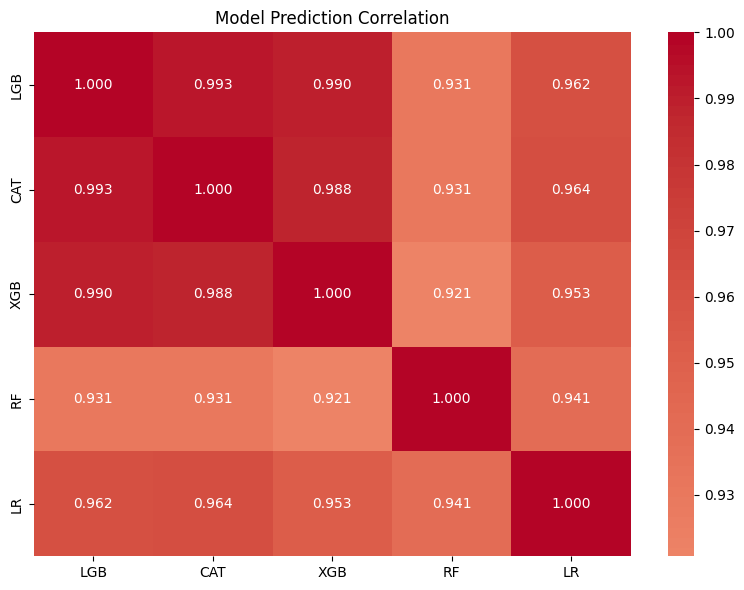

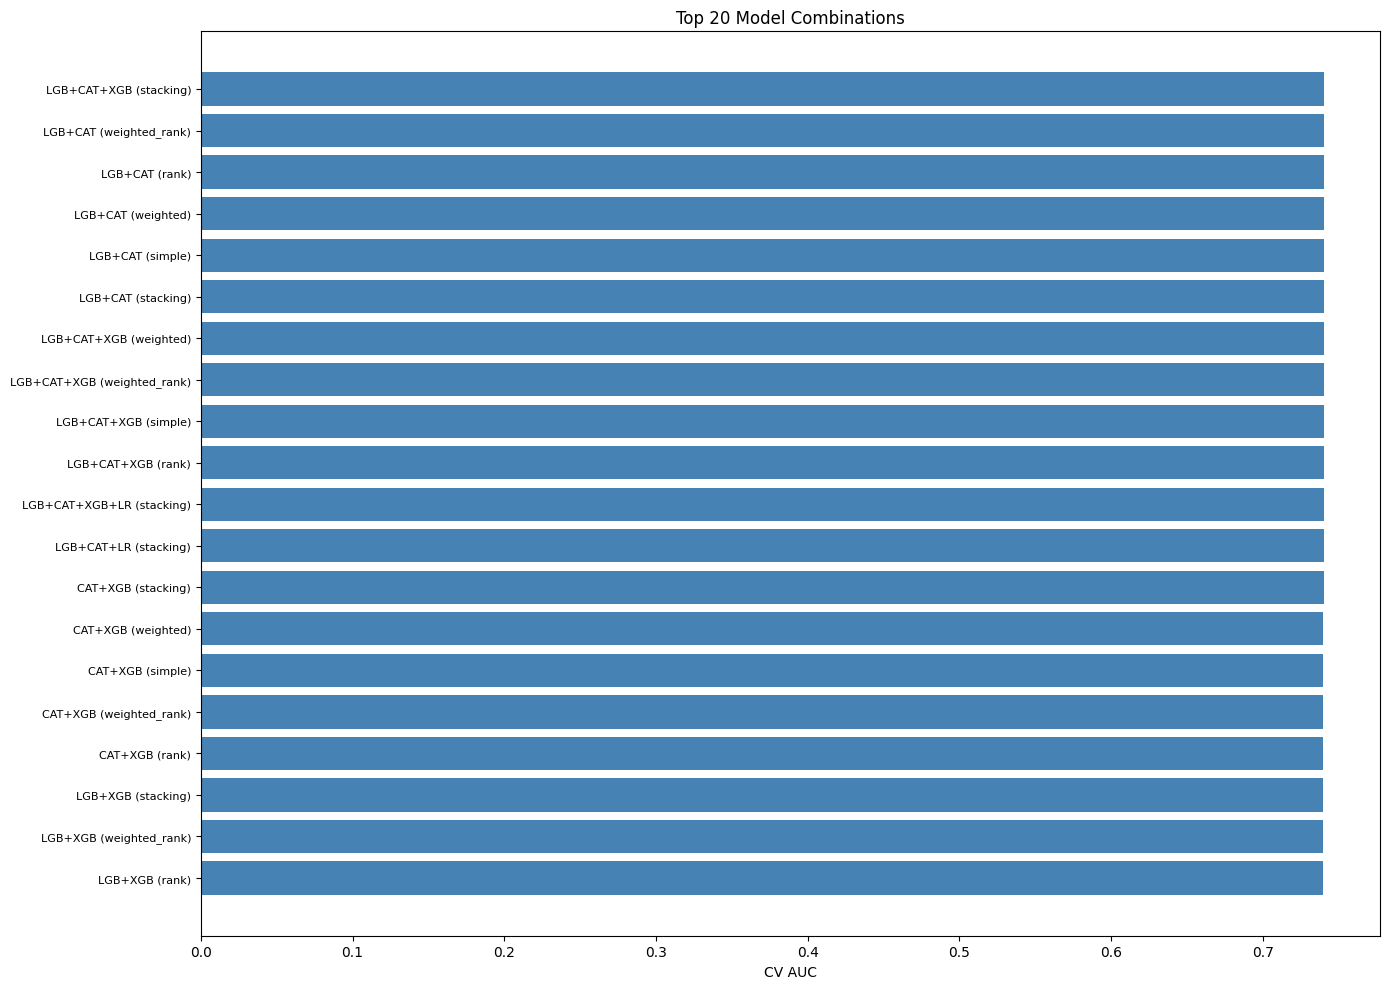

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from scipy.stats import rankdata
from itertools import combinations
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

print("="*80)
print("COMPREHENSIVE MODEL EXPERIMENT")
print("Testing: 6 Models × All Combinations × 5 Ensemble Methods")
print("="*80)

# ============================
# 1. 데이터 로드 및 전처리
# ============================
print("\n[1/10] Loading data...")
train_df = pd.read_csv("../data/train.csv")
test_df = pd.read_csv("../data/test.csv")
submission = pd.read_csv("../data/sample_submission.csv")

def preprocess(df):
    """전처리 함수 (기존과 동일)"""
    df_copy = df.copy()
    
    def major_procedure(x):
        if pd.isna(x):
            return "Unknown"
        if "IUI" in x:
            return "IUI"
        if "DI" in x:
            return "Other"
        if "ICSI" in x:
            return "ICSI"
        if "IVF" in x:
            return "IVF"
        return "Other"
    
    df_copy["시술_대분류"] = df_copy["특정 시술 유형"].apply(major_procedure)
    df_copy["BLASTOCYST_포함"] = df_copy["특정 시술 유형"].str.contains("BLASTOCYST", na=False).astype(int)
    
    embryo_stage_cols = [
        "단일 배아 이식 여부", "착상 전 유전 진단 사용 여부", "배아 생성 주요 이유",
        "총 생성 배아 수", "미세주입된 난자 수", "미세주입에서 생성된 배아 수",
        "이식된 배아 수", "미세주입 배아 이식 수", "저장된 배아 수",
        "미세주입 후 저장된 배아 수", "해동된 배아 수", "해동 난자 수",
        "수집된 신선 난자 수", "저장된 신선 난자 수", "혼합된 난자 수",
        "파트너 정자와 혼합된 난자 수", "기증자 정자와 혼합된 난자 수",
        "동결 배아 사용 여부", "신선 배아 사용 여부", "기증 배아 사용 여부", "대리모 여부",
    ]
    
    df_copy["배아_이식_미도달"] = df_copy[embryo_stage_cols].isna().all(axis=1).astype(int)
    df_copy["배아_이식_여부"] = 1 - df_copy["배아_이식_미도달"]
    
    def embryo_stage(row):
        if row['배아_이식_여부'] == 0:
            return '배아단계_미도달'
        elif pd.isna(row['총 생성 배아 수']) or row['총 생성 배아 수'] == 0:
            return '배아생성_실패'
        elif pd.isna(row['이식된 배아 수']) or row['이식된 배아 수'] == 0:
            return '이식_미실시'
        else:
            return '이식_완료'
    
    df_copy['배아_진행_단계'] = df_copy.apply(embryo_stage, axis=1)
    
    def collapse_trials(x):
        if x == '0회':
            return '0회'
        elif x in ['1회', '2회']:
            return '1–2회'
        else:
            return '3회 이상'
    
    df_copy["총시술_bin3"] = df_copy["총 시술 횟수"].apply(collapse_trials)
    
    def age_group_simple(age):
        if age == '알 수 없음':
            return 'Unknown'
        elif age == '만18-34세':
            return '34세 이하'
        elif age in ['만35-37세', '만38-39세']:
            return '35-39세'
        else:
            return '40세 이상'
    
    df_copy['나이_3구간'] = df_copy['시술 당시 나이'].apply(age_group_simple)
    
    def embryo_count_bin(count):
        if pd.isna(count) or count == 0:
            return '0개'
        elif count <= 2:
            return '1-2개'
        else:
            return '3개 이상'
    
    df_copy['이식배아_구간'] = df_copy['이식된 배아 수'].apply(embryo_count_bin)
    df_copy['Day5_이식_여부'] = (df_copy['배아 이식 경과일'] == 5.0).astype(int)
    
    infertility_cols = [
        "남성 주 불임 원인", "남성 부 불임 원인", "여성 주 불임 원인", "여성 부 불임 원인",
        "부부 주 불임 원인", "부부 부 불임 원인", "불명확 불임 원인",
        "불임 원인 - 난관 질환", "불임 원인 - 남성 요인", "불임 원인 - 배란 장애",
        "불임 원인 - 여성 요인", "불임 원인 - 자궁경부 문제", "불임 원인 - 자궁내막증",
        "불임 원인 - 정자 농도", "불임 원인 - 정자 면역학적 요인", "불임 원인 - 정자 운동성",
        "불임 원인 - 정자 형태"
    ]
    
    df_copy["불임_원인_개수"] = df_copy[infertility_cols].sum(axis=1)
    
    def infertility_complexity(count):
        if count == 0:
            return 'None'
        elif count == 1:
            return 'Single'
        elif count == 2:
            return 'Double'
        else:
            return 'Multiple'
    
    df_copy['불임원인_복잡도'] = df_copy['불임_원인_개수'].apply(infertility_complexity)
    df_copy['배아_해동_실시_여부'] = df_copy['배아 해동 경과일'].notna().astype(int)
    df_copy['배아_생성_효율'] = df_copy['총 생성 배아 수'] / (df_copy['수집된 신선 난자 수'] + 1)
    df_copy['배아_이식_비율'] = df_copy['이식된 배아 수'] / (df_copy['총 생성 배아 수'] + 1)
    df_copy['배아_저장_비율'] = df_copy['저장된 배아 수'] / (df_copy['총 생성 배아 수'] + 1)
    df_copy['나이×Day5'] = df_copy['시술 당시 나이'].astype(str) + '_' + df_copy['Day5_이식_여부'].astype(str)
    df_copy['시술횟수×나이'] = df_copy['총시술_bin3'] + '_' + df_copy['나이_3구간']
    
    return df_copy

train_df = preprocess(train_df)
test_df = preprocess(test_df)

feature_cols = [col for col in train_df.columns if col not in ['ID', '임신 성공 여부', '배아_이식_미도달']]
X_train = train_df[feature_cols].copy()
y_train = train_df['임신 성공 여부'].copy()
X_test = test_df[feature_cols].copy()

categorical_features = [
    '시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 유도 유형',
    '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수',
    'DI 시술 횟수', '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수',
    'IVF 출산 횟수', 'DI 출산 횟수', '난자 출처', '정자 출처', '난자 기증자 나이',
    '정자 기증자 나이', '시술_대분류', '총시술_bin3', '나이_3구간', '이식배아_구간',
    '불임원인_복잡도', '배아_진행_단계', '나이×Day5', '시술횟수×나이',
]

# Label Encoding
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

label_encoders = {}
for col in categorical_features:
    if col in X_train_encoded.columns:
        le = LabelEncoder()
        all_values = pd.concat([X_train_encoded[col], X_test_encoded[col]]).astype(str)
        le.fit(all_values)
        X_train_encoded[col] = le.transform(X_train_encoded[col].astype(str))
        X_test_encoded[col] = le.transform(X_test_encoded[col].astype(str))
        label_encoders[col] = le

# LightGBM용 category 타입
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
for col in categorical_features:
    if col in X_train_lgb.columns:
        X_train_lgb[col] = X_train_lgb[col].astype('category')
        X_test_lgb[col] = X_test_lgb[col].astype('category')

print(f"✅ Data loaded: Train {X_train.shape}, Test {X_test.shape}")

# ============================
# 2. Cross Validation 설정
# ============================
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 모델별 OOF, Test 예측 저장
models_predictions = {}

# ============================
# 3. Model 1: LightGBM
# ============================
print("\n[2/10] Training LightGBM...")
oof_lgb = np.zeros(len(X_train_lgb))
test_lgb = np.zeros(len(X_test_lgb))

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42,
}

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train_lgb, y_train), 1):
    X_tr, X_val = X_train_lgb.iloc[train_idx], X_train_lgb.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    train_data = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_features)
    valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, reference=train_data)
    
    model = lgb.train(lgb_params, train_data, num_boost_round=1000,
                     valid_sets=[valid_data], callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
    
    oof_lgb[valid_idx] = model.predict(X_val, num_iteration=model.best_iteration)
    test_lgb += model.predict(X_test_lgb, num_iteration=model.best_iteration) / skf.n_splits

lgb_auc = roc_auc_score(y_train, oof_lgb)
print(f"✅ LightGBM CV AUC: {lgb_auc:.6f}")
models_predictions['LGB'] = {'oof': oof_lgb, 'test': test_lgb, 'auc': lgb_auc}

# ============================
# 4. Model 2: CatBoost
# ============================
print("\n[3/10] Training CatBoost...")
cat_features_idx = [i for i, col in enumerate(feature_cols) if col in categorical_features]
oof_cat = np.zeros(len(X_train_encoded))
test_cat = np.zeros(len(X_test_encoded))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train_encoded, y_train), 1):
    X_tr, X_val = X_train_encoded.iloc[train_idx], X_train_encoded.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    model = cb.CatBoostClassifier(iterations=1000, learning_rate=0.05, depth=8,
                                   loss_function='Logloss', eval_metric='AUC',
                                   cat_features=cat_features_idx, random_seed=42,
                                   early_stopping_rounds=50, verbose=0)
    
    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), use_best_model=True, verbose=False)
    
    oof_cat[valid_idx] = model.predict_proba(X_val)[:, 1]
    test_cat += model.predict_proba(X_test_encoded)[:, 1] / skf.n_splits

cat_auc = roc_auc_score(y_train, oof_cat)
print(f"✅ CatBoost CV AUC: {cat_auc:.6f}")
models_predictions['CAT'] = {'oof': oof_cat, 'test': test_cat, 'auc': cat_auc}

# ============================
# 5. Model 3: XGBoost
# ============================
print("\n[4/10] Training XGBoost...")
oof_xgb = np.zeros(len(X_train_encoded))
test_xgb = np.zeros(len(X_test_encoded))

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'tree_method': 'hist',
}

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train_encoded, y_train), 1):
    X_tr, X_val = X_train_encoded.iloc[train_idx], X_train_encoded.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr, enable_categorical=False)
    dvalid = xgb.DMatrix(X_val, label=y_val, enable_categorical=False)
    
    model = xgb.train(xgb_params, dtrain, num_boost_round=1000,
                     evals=[(dvalid, 'valid')], early_stopping_rounds=50, verbose_eval=0)
    
    oof_xgb[valid_idx] = model.predict(dvalid)
    test_xgb += model.predict(xgb.DMatrix(X_test_encoded, enable_categorical=False)) / skf.n_splits

xgb_auc = roc_auc_score(y_train, oof_xgb)
print(f"✅ XGBoost CV AUC: {xgb_auc:.6f}")
models_predictions['XGB'] = {'oof': oof_xgb, 'test': test_xgb, 'auc': xgb_auc}

# ============================
# 6. Model 4: Random Forest
# ============================
print("\n[5/10] Training Random Forest...")
oof_rf = np.zeros(len(X_train_encoded))
test_rf = np.zeros(len(X_test_encoded))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train_encoded, y_train), 1):
    X_tr, X_val = X_train_encoded.iloc[train_idx], X_train_encoded.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    model = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=100,
                                   max_features='sqrt', random_state=42, n_jobs=-1)
    
    model.fit(X_tr, y_tr)
    
    oof_rf[valid_idx] = model.predict_proba(X_val)[:, 1]
    test_rf += model.predict_proba(X_test_encoded)[:, 1] / skf.n_splits

rf_auc = roc_auc_score(y_train, oof_rf)
print(f"✅ Random Forest CV AUC: {rf_auc:.6f}")
models_predictions['RF'] = {'oof': oof_rf, 'test': test_rf, 'auc': rf_auc}

# ============================
# 7. Model 5: Logistic Regression (Polynomial)
# ============================
print("\n[6/10] Training Logistic Regression...")

# 중요 변수만 선택 (Top 15)
important_cols = [
    '이식된 배아 수', '저장된 배아 수', '배아 이식 경과일', '총 생성 배아 수',
    '수집된 신선 난자 수', '시술 당시 나이', 'Day5_이식_여부',
    '배아_진행_단계', '나이_3구간', '이식배아_구간',
    '배아_생성_효율', '배아_이식_비율', '배아_저장_비율',
    '총 시술 횟수', '불임원인_복잡도'
]

# 범주형 -> 숫자형 변환 (이미 인코딩됨)
X_lr = X_train_encoded[[col for col in important_cols if col in X_train_encoded.columns]].copy()
X_lr_test = X_test_encoded[[col for col in important_cols if col in X_test_encoded.columns]].copy()

# 결측치 처리
X_lr = X_lr.fillna(-1)
X_lr_test = X_lr_test.fillna(-1)

oof_lr = np.zeros(len(X_lr))
test_lr = np.zeros(len(X_lr_test))

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_lr, y_train), 1):
    X_tr, X_val = X_lr.iloc[train_idx], X_lr.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
    
    # Polynomial features (2차)
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X_tr_poly = poly.fit_transform(X_tr)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_lr_test)
    
    # Scaling
    scaler = StandardScaler()
    X_tr_poly = scaler.fit_transform(X_tr_poly)
    X_val_poly = scaler.transform(X_val_poly)
    X_test_poly = scaler.transform(X_test_poly)
    
    # Logistic Regression
    model = LogisticRegression(C=0.1, max_iter=1000, random_state=42, n_jobs=-1)
    model.fit(X_tr_poly, y_tr)
    
    oof_lr[valid_idx] = model.predict_proba(X_val_poly)[:, 1]
    test_lr += model.predict_proba(X_test_poly)[:, 1] / skf.n_splits

lr_auc = roc_auc_score(y_train, oof_lr)
print(f"✅ Logistic Regression CV AUC: {lr_auc:.6f}")
models_predictions['LR'] = {'oof': oof_lr, 'test': test_lr, 'auc': lr_auc}

# ============================
# 8. 모델 상관관계 분석
# ============================
print("\n[7/10] Analyzing model diversity...")

correlation_df = pd.DataFrame({
    'LGB': oof_lgb,
    'CAT': oof_cat,
    'XGB': oof_xgb,
    'RF': oof_rf,
    'LR': oof_lr
})

corr_matrix = correlation_df.corr()
print("\n=== Model Correlation Matrix ===")
print(corr_matrix.round(4))

# 시각화
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0.8, ax=ax)
ax.set_title('Model Prediction Correlation')
plt.tight_layout()
plt.savefig('../outputs/model_correlation_heatmap.png', dpi=150)
print("✅ Correlation heatmap saved")

# ============================
# 9. 모든 조합 앙상블 테스트
# ============================
print("\n[8/10] Testing all ensemble combinations...")

def ensemble_predictions(model_names, oof_dict, test_dict, method='simple', weights=None):
    """앙상블 예측 함수"""
    oof_list = [oof_dict[m] for m in model_names]
    test_list = [test_dict[m] for m in model_names]
    
    if method == 'simple':
        oof_pred = np.mean(oof_list, axis=0)
        test_pred = np.mean(test_list, axis=0)
        
    elif method == 'weighted':
        if weights is None:
            weights = np.array([models_predictions[m]['auc'] for m in model_names])
            weights = weights / weights.sum()
        oof_pred = np.average(oof_list, axis=0, weights=weights)
        test_pred = np.average(test_list, axis=0, weights=weights)
        
    elif method == 'rank':
        rank_oof = [rankdata(oof) / len(oof) for oof in oof_list]
        rank_test = [rankdata(test) / len(test) for test in test_list]
        oof_pred = np.mean(rank_oof, axis=0)
        test_pred = np.mean(rank_test, axis=0)
        
    elif method == 'weighted_rank':
        if weights is None:
            weights = np.array([models_predictions[m]['auc'] for m in model_names])
            weights = weights / weights.sum()
        rank_oof = [rankdata(oof) / len(oof) for oof in oof_list]
        rank_test = [rankdata(test) / len(test) for test in test_list]
        oof_pred = np.average(rank_oof, axis=0, weights=weights)
        test_pred = np.average(rank_test, axis=0, weights=weights)
        
    elif method == 'stacking':
        # Proper OOF Stacking (meta model also CV)
        meta_train = np.column_stack(oof_list)
        meta_test  = np.column_stack(test_list)

        meta_oof  = np.zeros(len(y_train))
        meta_pred = np.zeros(len(meta_test))

        skf_meta = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        for tr_idx, va_idx in skf_meta.split(meta_train, y_train):
            Xtr, Xva = meta_train[tr_idx], meta_train[va_idx]
            ytr, yva = y_train.iloc[tr_idx], y_train.iloc[va_idx]

            meta_model = LogisticRegression(C=0.1, random_state=42, max_iter=2000)
            meta_model.fit(Xtr, ytr)

            meta_oof[va_idx] = meta_model.predict_proba(Xva)[:, 1]
            meta_pred += meta_model.predict_proba(meta_test)[:, 1] / skf_meta.n_splits

        oof_pred = meta_oof
        test_pred = meta_pred

    return oof_pred, test_pred

# 모든 조합 시도
all_model_names = list(models_predictions.keys())
oof_dict = {name: models_predictions[name]['oof'] for name in all_model_names}
test_dict = {name: models_predictions[name]['test'] for name in all_model_names}

results = []

# 개별 모델
for name in all_model_names:
    results.append({
        'models': name,
        'n_models': 1,
        'method': 'single',
        'cv_auc': models_predictions[name]['auc']
    })

# 2~5개 조합
ensemble_methods = ['simple', 'weighted', 'rank', 'weighted_rank', 'stacking']

for n in range(2, 6):
    combos = list(combinations(all_model_names, n))
    print(f"  Testing {len(combos)} combinations of {n} models...")
    
    for combo in combos:
        for method in ensemble_methods:
            oof_pred, test_pred = ensemble_predictions(combo, oof_dict, test_dict, method)
            auc = roc_auc_score(y_train, oof_pred)
            
            results.append({
                'models': '+'.join(combo),
                'n_models': n,
                'method': method,
                'cv_auc': auc
            })

results_df = pd.DataFrame(results).sort_values('cv_auc', ascending=False)

print("\n=== Top 30 Combinations ===")
print(results_df.head(30).to_string(index=False))

# CSV 저장
results_df.to_csv('../outputs/comprehensive_experiment_results.csv', index=False)
print("\n✅ Results saved: ../outputs/comprehensive_experiment_results.csv")

# ============================
# 10. 시각화 및 최종 제출
# ============================
print("\n[9/10] Creating visualizations...")

# Top 20 막대그래프
fig, ax = plt.subplots(figsize=(14, 10))
top20 = results_df.head(20)
colors = ['red' if 'single' in m else 'steelblue' for m in top20['method']]
ax.barh(range(len(top20)), top20['cv_auc'], color=colors)
ax.set_yticks(range(len(top20)))
ax.set_yticklabels([f"{row['models']} ({row['method']})" for _, row in top20.iterrows()], fontsize=8)
ax.set_xlabel('CV AUC')
ax.set_title('Top 20 Model Combinations')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../outputs/top20_combinations.png', dpi=150)
print("✅ Top 20 plot saved")

# 최고 성능 조합으로 제출
print("\n[10/10] Generating final submission...")
best_row = results_df.iloc[0]
print(f"\n🏆 Best Combination:")
print(f"   Models: {best_row['models']}")
print(f"   Method: {best_row['method']}")
print(f"   CV AUC: {best_row['cv_auc']:.6f}")

# 최고 조합으로 예측 재생성
best_models = best_row['models'].split('+')
best_method = best_row['method']

if best_method == 'single':
    final_test_pred = test_dict[best_models[0]]
else:
    _, final_test_pred = ensemble_predictions(best_models, oof_dict, test_dict, best_method)

submission['probability'] = final_test_pred
submission.to_csv("../outputs/submission_comprehensive_best(0206).csv", index=False)

print("\n✅ Submission saved: submission_comprehensive_best(0206).csv")

# 요약 저장
summary = f"""
=== COMPREHENSIVE EXPERIMENT SUMMARY ===

Total Combinations Tested: {len(results_df)}
Individual Models: {len(all_model_names)}

Individual Model Performance:
"""

for name in all_model_names:
    summary += f"  {name}: {models_predictions[name]['auc']:.6f}\n"

summary += f"""
Best Combination:
  Models: {best_row['models']}
  Method: {best_row['method']}
  CV AUC: {best_row['cv_auc']:.6f}

Improvement over best single model: +{best_row['cv_auc'] - max([m['auc'] for m in models_predictions.values()]):.6f}

Top 5 Combinations:
"""

for i, row in results_df.head(5).iterrows():
    summary += f"  {i+1}. {row['models']} ({row['method']}): {row['cv_auc']:.6f}\n"

print(summary)

with open("../outputs/comprehensive_summary.txt", "w") as f:
    f.write(summary)

print("\n" + "="*80)
print("COMPREHENSIVE EXPERIMENT COMPLETE! 🎉")
print("="*80)